# Permitted Emissions in Minneapolis (MPCA)

These are all the Hennepin County annual permitted emissions for the years 2006 to 2019

Size: ~ 8mb

Source: https://www.pca.state.mn.us/air/permitted-facility-air-emissions-data

In [1]:
### Import Libraries

# File manipulation

import os # For working with Operating System
from sys import platform # Diagnose operating system
import shutil # For deleting folders
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects

# Analysis

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd # Spatial Data Manipulation

# Visualization

import matplotlib.pyplot as plt # Basic Plotting
import seaborn as sns # Statistical Plotting
import contextily # Base Map Visualization

In [2]:
### Definitions

cwd = os.getcwd() # Current Working Directory

# Forward or back slashs for filepaths? <- Not sure here. Only know Windows & Linux

if platform == "linux" or platform == "linux2":
    slash = '/'
elif platform == 'win32':
    slash = '\\'

def extract_zip_from_url(urls=None):
    '''Extract a zipfile from the internet and unpack it in working directory.
    Takes a single url (string) or a list of urls.'''
    
    if type(urls) == str: # Single url
        url = urls
        response = urllib.request.urlopen(url) # Get a response
        zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
        zip_folder.extractall() # Extract files
    
    elif type(urls) == list: # List of urls
        for url in urls:
            response = urllib.request.urlopen(url) # Get a response
            zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
            zip_folder.extractall() # Extract files
            
    else:
        print('Error Extracting: Invalid Input')

def clip_to_extent(gdf):
    '''This function returns the dataset clipped to the boundaries of Minneapolis and the boundary itself.
    Warning: This function will download the shapefile of Minneapolis (<1mb) if it's not in the current working directory as mpls_boundary.shp.
    See this link for more info: https://github.com/RwHendrickson/MappingGZ/blob/main/Prototype/Notebooks/CleaningData/Boundary/DefineBoundary.ipynb'''
    
    # Download boundary if not in working directory  
    
    if 'mpls_boundary.shp' not in os.listdir():
        url = 'https://github.com/RwHendrickson/MappingGZ/raw/main/Prototype/Notebooks/CleaningData/Boundary/mpls_boundary.zip'
        extract_zip_from_url(url)
        
    mpls_boundary = gpd.read_file('mpls_boundary.shp') # Load extent as GeoDataFrame
    
    if gdf.crs != 'EPSG:26915': # Ensures gdf is in the same CRS
        gdf = gdf.to_crs('EPSG:26915')
    
    clipped = gpd.clip(gdf, mpls_boundary) # Clip
    
    return clipped, mpls_boundary

In [3]:
### Load Data

## Permitted Emissions

emissions = pd.read_csv('MPCA_Permitted_Emissions_Full.csv') # Load as DataFrame

emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64393 entries, 0 to 64392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Facility name            64393 non-null  object 
 1   Year                     64393 non-null  int64  
 2   Pollutant                64393 non-null  object 
 3   County                   64393 non-null  object 
 4   Facility ID              64393 non-null  int64  
 5   Pollutant group          64393 non-null  object 
 6   Emissions (Lbs)          64393 non-null  float64
 7   Emissions (LBs) (copy)   64393 non-null  float64
 8   Emissions (Tons)         64149 non-null  float64
 9   Emissions (Tons) (copy)  64149 non-null  float64
 10  STANDARDIZED_LATITUDE    64322 non-null  float64
 11  STANDARDIZED_LONGITUDE   64322 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 5.9+ MB


---

## **Cleaning**

---

In [4]:
### Clean Coordinates

# Initialize

coords = list(zip(emissions.STANDARDIZED_LONGITUDE,
                  emissions.STANDARDIZED_LATITUDE)) # Zip into list of coordinates stored as tuples

good_indices = [] # Store indices
bad_indices = []

for i, coord in enumerate(coords):
    if coord[0] > -93 or coord[0] < -94: # Bad Longitude
        bad_indices.append(i)
    elif coord[1] > 45.3 or coord[1] < 44.8: # Bad Latitude
        bad_indices.append(i)
    elif 'nan' in str(coord[0]) or 'nan' in str(coord[0]): # Not a number
        bad_indices.append(i)
    else:
        good_indices.append(i)
        
bad_data = emissions.iloc[bad_indices]
good_data = emissions.iloc[good_indices]

print(f"Facilities: {bad_data['Facility name'].unique()}") # intersesting let's fix this!


Facilities: ['Xcel Energy - General Office' 'CS McCrossan Inc - Stationary'
 'Midwest Asphalt Corp - Nonmetallic' 'Hardrives Inc - Nonmetallic'
 'Hassan Sand & Gravel Inc - Nonmetallic']


In [5]:
# Find coords for companies with missing data

bad_facilities = bad_data['Facility name'].unique()

for facility in bad_facilities:
    print(np.isin(facility, good_data['Facility name'])) # Hmm! 
    
    # Looks like Xcel Energy's General Office has a valid location in the data, 
    # but the others do not. I'll google them sometime to see if they're in the
    # extent of this study
    
    # But Not today!

True
False
False
False
False


---

## **Plotting**

---

In [6]:
## Spatialize

emissions_geo = gpd.GeoDataFrame(good_data, geometry=gpd.points_from_xy\
                            (good_data.STANDARDIZED_LONGITUDE, good_data.STANDARDIZED_LATITUDE)
                               ) # Points from xy

emissions_geo.crs = 'EPSG:4326' # Initialize CRS

emissions_geo = emissions_geo.to_crs('EPSG:26915') # Localize CRS

mpls_emissions, mpls_bound = clip_to_extent(emissions_geo) # Clip to extent

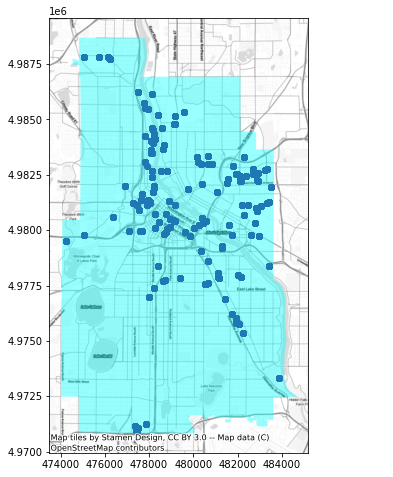

In [7]:
### Check points

f,ax = plt.subplots(1,1, figsize=(8,8))

mpls_bound.plot(ax = ax,
               cmap = 'cool',
               alpha = .4)

mpls_emissions.plot(ax = ax)


contextily.add_basemap(ax = ax, 
                       crs = mpls_bound.crs, 
                       source = contextily.providers.Stamen.TonerLite
                      )

---

## Focusing

---

In [8]:
# Focus the data

focus = mpls_emissions[['Facility name', 'Facility ID', 'Year', 'Pollutant', 'Pollutant group', 
                                  'Emissions (Lbs)', 'Emissions (Tons)', 'geometry']] # Select relevant columns

focus = focus.rename(columns={'Facility name':'Facility', 'Facility ID':'Facility_ID','Pollutant group':'Pollutant_gp',\
                                        'Emissions (Lbs)':'Lbs_Emitted','Emissions (Tons)':'Tons_Emitted'}) # Easier names


print(focus.info()) # Show column names/types/etc.
focus.head() # Look at first entries

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 22955 entries, 16016 to 13610
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Facility      22955 non-null  object  
 1   Facility_ID   22955 non-null  int64   
 2   Year          22955 non-null  int64   
 3   Pollutant     22955 non-null  object  
 4   Pollutant_gp  22955 non-null  object  
 5   Lbs_Emitted   22955 non-null  float64 
 6   Tons_Emitted  22873 non-null  float64 
 7   geometry      22955 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(3)
memory usage: 1.6+ MB
None


,Facility,Facility_ID,Year,Pollutant,Pollutant_gp,Lbs_Emitted,Tons_Emitted,geometry
16016,Acme Foundry Co,5300017,2011,Fluorene,Air toxic,0.000000,0.000000,POINT (481413.439 4976878.549)
10167,Acme Foundry Co,5300017,2007,Carbon Monoxide,Criteria,0.000000,0.000000,POINT (481413.439 4976878.549)
50186,Acme Foundry Co,5300017,2017,Dichlorobenzenes,Air toxic,0.002748,0.000001,POINT (481413.439 4976878.549)
48736,Acme Foundry Co,5300017,2011,Sulfur Dioxide,Criteria,0.920000,0.000000,POINT (481413.439 4976878.549)
16097,Acme Foundry Co,5300017,2011,Formaldehyde,Air toxic,0.120000,0.000000,POINT (481413.439 4976878.549)


---

## Exploring

---

In [9]:
## Find unique values

facilities_geo = focus.dissolve('Facility_ID')[['Facility','geometry']] # facilites
years = focus['Year'].unique() # years
pollutant_gps = focus['Pollutant_gp'].unique() # pollutant groups

print(pollutant_gps)
print("\nLet's look at Criteria & Air toxic")

['Air toxic' 'Criteria' 'Greenhouse Gas' 'Greenhouse gas']

Let's look at Criteria & Air toxic


In [10]:
## Query

criteria = focus.loc[focus['Pollutant_gp'] == 'Criteria']
toxics = focus.loc[focus['Pollutant_gp'] == 'Air toxic']

### Pollutants of interest

crit_pollutants = criteria['Pollutant'].unique()
toxic_pollutants = toxics['Pollutant'].unique()

print('Criteria Pollutants', crit_pollutants) # Not too many
# print(toxic_pollutants) # Lots! - I know the benchmarks for Benzene and Naphthalene? Part of Greater VOC Family

Criteria Pollutants ['Carbon Monoxide' 'Sulfur Dioxide' 'PM2.5 Primary' 'PM10 Primary'
 'Volatile Organic Compounds' 'PM Primary' 'Ammonia' 'Nitrogen Oxides'
 'Lead']


In [11]:
## Maybe sum them up?

# Group by Year, facility, pollutant_gp
tox_gp = toxics.groupby(['Year','Facility_ID', 'Pollutant_gp'])

toxic_lbs = tox_gp.sum()

# This is where I'll stop for now

In [12]:
toxic_lbs

Lbs_Emitted  Tons_Emitted
Year Facility_ID Pollutant_gp                            
2008 5300002     Air toxic       983.890000      0.480000
     5300006     Air toxic       170.680000      0.080000
     5300009     Air toxic         3.560000      0.000000
     5300011     Air toxic      2630.430000      1.300000
     5300015     Air toxic     84996.420000     42.510000
...                                     ...           ...
2017 5301245     Air toxic       421.672372      0.210836
     5301246     Air toxic       112.887104      0.056444
     5301260     Air toxic      4059.654206      2.029827
     5301261     Air toxic       326.144219      0.163072
     5301265     Air toxic         0.227681      0.000114

[515 rows x 2 columns]